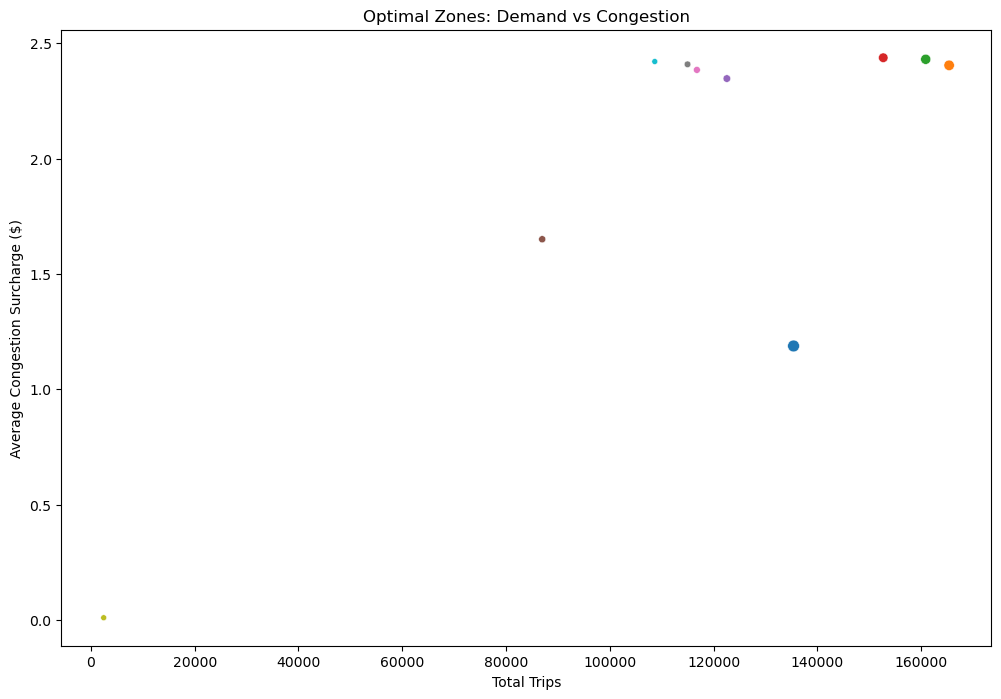

Optimal Zones:

                         pu_zone  optimization_score  total_trips  \
3                    JFK Airport            0.701138       135398   
0                 Midtown Center            0.615259       165378   
1          Upper East Side South            0.594707       160865   
2          Upper East Side North            0.563937       152684   
4      Times Sq/Theatre District            0.469045       122545   
13             LaGuardia Airport            0.451376        86959   
5   Penn Station/Madison Sq West            0.442110       116774   
6                   Midtown East            0.431670       114968   
65                 East New York            0.407293         2458   
7            Lincoln Square East            0.406836       108654   

    avg_congestion  
3         1.188084  
0         2.404632  
1         2.430749  
2         2.437554  
4         2.347218  
13        1.650725  
5         2.384702  
6         2.408997  
65        0.010154  
7         2.42

In [17]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data with error handling
def load_data(trip_file_path, zone_file_path):
    try:
        trip_df = pq.read_table(trip_file_path).to_pandas()
        zone_df = pd.read_csv(zone_file_path)
        return trip_df, zone_df
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

# Enhanced preprocessing
def preprocess_data(trip_df, zone_df):
    # Merge zone data
    zone_rename = {'Borough': 'borough', 'Zone': 'zone', 'service_zone': 'service_zone'}
    
    trip_df = trip_df.merge(
        zone_df.rename(columns=zone_rename), 
        left_on='PULocationID', 
        right_on='LocationID',
        how='left'
    ).rename(columns={c: f'pu_{c}' for c in zone_rename.values()})
    
    trip_df = trip_df.merge(
        zone_df.rename(columns=zone_rename), 
        left_on='DOLocationID', 
        right_on='LocationID',
        how='left'
    ).rename(columns={c: f'do_{c}' for c in zone_rename.values()})
    
    # Handle datetimes and durations
    trip_df['tpep_pickup_datetime'] = pd.to_datetime(trip_df['tpep_pickup_datetime'], errors='coerce')
    trip_df['tpep_dropoff_datetime'] = pd.to_datetime(trip_df['tpep_dropoff_datetime'], errors='coerce')
    
    # Calculate trip duration in hours (handle invalid/negative durations)
    trip_df['duration_hrs'] = (
        (trip_df['tpep_dropoff_datetime'] - trip_df['tpep_pickup_datetime'])
        .dt.total_seconds()
        .div(3600)
        .clip(lower=0.1)  # Minimum 6 seconds to avoid division by zero
    )
    
    # Calculate speed (mph)
    trip_df['speed_mph'] = trip_df['trip_distance'] / trip_df['duration_hrs']
    
    # Filter invalid data
    valid_mask = (
        (trip_df['pu_zone'] != 'Outside of NYC') &
        (trip_df['do_zone'] != 'Outside of NYC') &
        (trip_df['speed_mph'].between(1, 100))  # Plausible speed range
    )
    
    return trip_df[valid_mask].copy()

# Demand analysis with zone grouping
def analyze_demand(trip_df):
    # Top zones by trip volume
    zone_demand = trip_df.groupby('pu_zone').agg(
        total_trips=('pu_zone', 'size'),
        avg_passengers=('passenger_count', 'mean'),
        avg_distance=('trip_distance', 'mean')
    ).reset_index()
    
    return zone_demand.sort_values('total_trips', ascending=False)

# Congestion analysis with error handling
def analyze_congestion(trip_df):
    if 'congestion_surcharge' not in trip_df.columns:
        raise KeyError("congestion_surcharge column missing in trip data")
    
    congestion = trip_df.groupby('pu_zone').agg(
        avg_congestion=('congestion_surcharge', 'mean'),
        total_congestion=('congestion_surcharge', 'sum'),
        avg_speed=('speed_mph', 'mean')
    ).reset_index()
    
    return congestion

# Route optimization
def optimize_routes(demand_df, congestion_df):
    merged = pd.merge(
        demand_df,
        congestion_df,
        on='pu_zone',
        how='inner'
    )
    
    # Normalize metrics
    merged['demand_norm'] = merged['total_trips'] / merged['total_trips'].max()
    merged['congestion_norm'] = 1 - (merged['avg_congestion'] / merged['avg_congestion'].max())
    
    # Weighted score
    merged['optimization_score'] = (
        0.6 * merged['demand_norm'] + 
        0.4 * merged['congestion_norm']
    )
    
    return merged.sort_values('optimization_score', ascending=False).head(10)

# Main analysis
def main(trip_path, zone_path):
    trip_df, zone_df = load_data(trip_path, zone_path)
    trip_df = preprocess_data(trip_df, zone_df)
    
    demand = analyze_demand(trip_df)
    congestion = analyze_congestion(trip_df)
    
    optimal = optimize_routes(demand, congestion)
    
    # Visualizations
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='total_trips', 
        y='avg_congestion', 
        size='optimization_score',
        hue='pu_zone',
        data=optimal,
        legend=False
    )
    plt.title('Optimal Zones: Demand vs Congestion')
    plt.xlabel('Total Trips')
    plt.ylabel('Average Congestion Surcharge ($)')
    plt.show()
    
    return optimal

if __name__ == "__main__":
    try:
        results = main(
            "yellow_tripdata_2025-01.parquet", 
            "taxi_zone_lookup.csv"
        )
        print("Optimal Zones:\n")
        print(results[['pu_zone', 'optimization_score', 'total_trips', 'avg_congestion']])
    except Exception as e:
        print(f"Analysis failed: {str(e)}")